In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [4]:
# Dataset folders 
dataset_dir = '/kaggle/input/an2dl-challenge-1-nt/data_splitted_no_test'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [5]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation
train_data_gen = ImageDataGenerator(rotation_range=30, 
                                    height_shift_range=0.2, 
                                    width_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True, 
                                    shear_range=0.2, 
                                    fill_mode='reflect',
                                    rescale=1/255.) # rescale value is multiplied to the image ############################################
valid_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3648 images belonging to 8 classes.
Found 648 images belonging to 8 classes.


## Model

In [6]:
# to create a folder
import os
directory = "ResNet152V2"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
os.mkdir(path)

In [7]:
!cd /kaggle/working/ResNet152V2

In [8]:
# Download and plot the ResNet152V2 model
resnet = tfk.applications.ResNet152V2(
    include_top=False, # we are using only the conv part of the network, and not the FC part
    weights="imagenet",
    input_shape=(96,96,3)
)
resnet.trainable = False # we are freezing the weights of the conv part, so that they are not updated
                            # during the training

234561536/234545216 [==============================] - 7s 0us/step


In [9]:
input_shape = (96, 96, 3)
epochs = 200

In [10]:
def resnet152v2(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    #x = tfkl.Resizing(64, 64, interpolation="bicubic", name='resizing')(input_layer)
    rn = resnet(input_layer)

    gap = tfkl.GlobalAveragePooling2D()(rn)
    drop1 = tfkl.Dropout(0.2, seed=seed)(gap)
    classifier_layer1 = tfkl.Dense(units=512, name='Classifier1', kernel_initializer=tfk.initializers.HeUniform(seed))(drop1)
    act1 = tfkl.Activation("relu")(classifier_layer1)
    batch1 = tfkl.BatchNormalization()(act1)
    drop2 = tfkl.Dropout(0.2, seed=seed)(batch1)
    classifier_layer2 = tfkl.Dense(units=60, name='Classifier2', kernel_initializer=tfk.initializers.HeUniform(seed))(drop2)
    act2 = tfkl.Activation("relu")(classifier_layer2)
    batch2 = tfkl.BatchNormalization()(act2)
    drop3 = tfkl.Dropout(0.2, seed=seed)(batch2)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(drop3)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.RMSprop(learning_rate=0.01), metrics='accuracy')

    # Return the model
    return model

## Training

In [11]:
# Build model
RN = resnet152v2(input_shape)
RN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 3, 3, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Classifier1 (Dense)          (None, 512)               1049088   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048  

In [12]:
# Train the model
RN_history = RN.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)],
).history

Epoch 1/200
456/456 [==============================] - 52s 83ms/step - loss: 1.9154 - accuracy: 0.2966 - val_loss: 1.6232 - val_accuracy: 0.3688
Epoch 2/200
456/456 [==============================] - 25s 54ms/step - loss: 1.7156 - accuracy: 0.3525 - val_loss: 1.5791 - val_accuracy: 0.4352
Epoch 3/200
456/456 [==============================] - 21s 47ms/step - loss: 1.6815 - accuracy: 0.3758 - val_loss: 1.4971 - val_accuracy: 0.4522
Epoch 4/200
456/456 [==============================] - 22s 47ms/step - loss: 1.6422 - accuracy: 0.3893 - val_loss: 1.4786 - val_accuracy: 0.4583
Epoch 5/200
456/456 [==============================] - 21s 46ms/step - loss: 1.6109 - accuracy: 0.3923 - val_loss: 1.5024 - val_accuracy: 0.4568
Epoch 6/200
456/456 [==============================] - 22s 47ms/step - loss: 1.6085 - accuracy: 0.4082 - val_loss: 1.4726 - val_accuracy: 0.4444
Epoch 7/200
456/456 [==============================] - 22s 48ms/step - loss: 1.5720 - accuracy: 0.4156 - val_loss: 1.4249 - val_ac

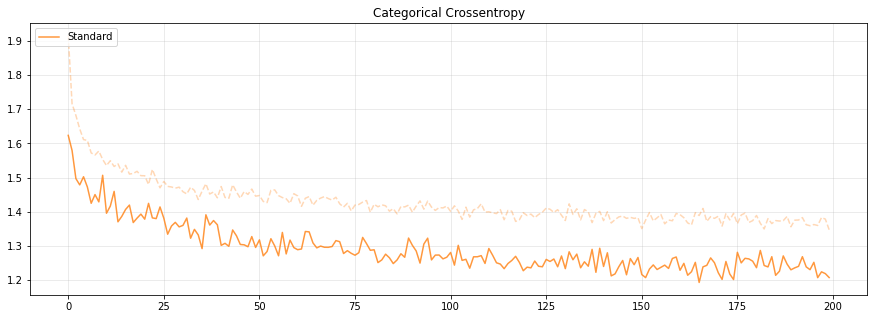

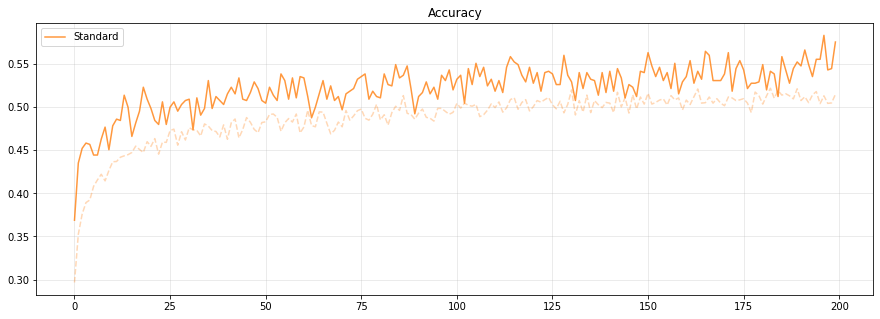

In [13]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(RN_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(RN_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig('RN_v1.0.3_loss.png')

plt.figure(figsize=(15,5))
plt.plot(RN_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(RN_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig('RN_v1.0.3_acc.png')

plt.show()

In [14]:
# Save the best model
RN.save('RN_v1.0.3')

In [15]:
# Evaluate on val
val_metrics = RN.evaluate(valid_gen, return_dict=True)

print()
print("Val metrics")
print(val_metrics)

81/81 [==============================] - 3s 31ms/step - loss: 1.2080 - accuracy: 0.5756

Val metrics
{'loss': 1.207972526550293, 'accuracy': 0.5756173133850098}
